# Sex-Specific Alzheimer's Disease Modelling Experimentations

## Set-up and Cleaning

In [30]:
# === Load and clean data ===
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from scipy import stats

#p_value = ttest_rel(baseline_fold_metrics, sex_specific_fold_metrics).pvalue




In [31]:
# Load OASIS dataset
df = pd.read_csv("oasis_longitudinal.csv")
print(df)

    Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  \
0    OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87   
1    OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88   
2    OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75   
3    OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76   
4    OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80   
..         ...            ...          ...    ...       ...  ..  ...  ...   
368  OAS2_0185  OAS2_0185_MR2     Demented      2       842   M    R   82   
369  OAS2_0185  OAS2_0185_MR3     Demented      3      2297   M    R   86   
370  OAS2_0186  OAS2_0186_MR1  Nondemented      1         0   F    R   61   
371  OAS2_0186  OAS2_0186_MR2  Nondemented      2       763   F    R   63   
372  OAS2_0186  OAS2_0186_MR3  Nondemented      3      1608   F    R   65   

     EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
0      14  2.0  27.0  0.0  

In [32]:
# Fill missing SES and MMSE values
df['SES'] = df['SES'].fillna(df['SES'].median())
df['MMSE'] = df['MMSE'].fillna(df['MMSE'].mean())

In [33]:
# Convert labels to binary classification: demented = 1, nondemented = 0
df['Group'] = df['Group'].replace("Converted", "Demented")
df['Group'] = df['Group'].map({"Demented": 1, "Nondemented": 0})

In [34]:
# Define features and dropping missing values
my_features = ['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
df_clean = df.dropna(subset=my_features + ['Group', 'M/F'])

## Repeated Train/Test Evaluation Function

In [74]:

# === REPEATED TRAIN/TEST EVALUATION ===

def repeated_evaluation(model, X, y, label, splits, sex=None, sex_filter=None):
    fold_metrics = []
    for repeat, fold, train_idx, test_idx in splits:
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            if len(train_idx) == 0 or len(test_idx) == 0:
                continue
            scaler = StandardScaler() 
            X_train_scaled = scaler.fit_transform(X_train) 
            X_test_scaled = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
            if sex is not None and sex_filter is not None:
                test_sex = sex.iloc[test_idx]
                mask = test_sex == sex_filter
                if not mask.any():
                    continue
                y_test = y_test[mask]
                y_pred = y_pred[mask]
                y_proba = y_proba[mask]

            fold_metrics.append({
                'repeat': repeat,
                'fold': fold,
                'accuracy': accuracy_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_proba)
            })

    metrics_df = pd.DataFrame(fold_metrics)
    metrics = metrics_df[['accuracy', 'f1', 'precision', 'recall', 'roc_auc']]
    means = metrics.mean()
    stds = metrics.std()
    summary = [
        label,
        means['accuracy'], stds['accuracy'],
        means['f1'], stds['f1'],
        means['precision'], stds['precision'],
        means['recall'], stds['recall'],
        means['roc_auc'], stds['roc_auc']
    ]
   
    return summary, metrics_df

In [76]:

X_all = df_clean[my_features]
y_all = df_clean['Group']
sex_all = df_clean['M/F']
groups_all = df_clean['Subject ID']

In [112]:
# Compute cross-validation splits
splits_all = []
for repeat in range(10):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42 + repeat)
    for fold, (train_idx, test_idx) in enumerate(sgkf.split(X_all, y_all, groups_all)):
        splits_all.append((repeat, fold, train_idx, test_idx))
male_idx = np.where(sex_all == 'M')[0]
female_idx = np.where(sex_all == 'F')[0]
splits_m, splits_f = [], []
for repeat, fold, train_idx, test_idx in splits_all:
    m_train = np.intersect1d(train_idx, male_idx)
    m_test = np.intersect1d(test_idx, male_idx)
    if len(m_train) and len(m_test):
        splits_m.append((repeat, fold, m_train, m_test))
    f_train = np.intersect1d(train_idx, female_idx)
    f_test = np.intersect1d(test_idx, female_idx)
    if len(f_train) and len(f_test):
        splits_f.append((repeat, fold, f_train, f_test))

## Logistic Regression and Random Forest Classifier Models

In [160]:

# === General models ===
LR_RF_results = []
results_folds = {}

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-All", splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-All"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-All", splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-All"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-M", sex=sex_all, sex_filter='M', splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-M"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-F", sex=sex_all, sex_filter='F', splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-F"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-M", sex=sex_all, sex_filter='M', splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-M"] = folds
summary, fold = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-F", sex=sex_all, sex_filter='F', splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-F"] = folds


In [162]:

# === Sex specific models ===

df_male = df_clean[df_clean['M/F'] == 'M']
df_female = df_clean[df_clean['M/F'] == 'F']
groups_f = df_female['Subject ID']
groups_m = df_male['Subject ID']

X_m, y_m = df_male[my_features], df_male['Group']

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Male-LR-M", splits=splits_m)
LR_RF_results.append(summary)
results_folds["Male-LR-M"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Male-RF-M", splits=splits_m)
LR_RF_results.append(summary)
results_folds["Male-RF-M"] = folds

X_f, y_f = df_female[my_features], df_female['Group']

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Female-LR-F", splits=splits_f)
LR_RF_results.append(summary)
results_folds["Female-LR-F"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Female-RF-F", splits=splits_f)
LR_RF_results.append(summary)
results_folds["Female-RF-F"] = folds



[['Gen-LR-All', 0.9458487301308749, 0.024046794373722837, 0.9414147031959316, 0.025454254220303306, 0.985503693275588, 0.019580943948181072, 0.9019579935986697, 0.04027441574551384, 0.9653424800977366, 0.024435197265698882], ['Gen-RF-All', 0.9412535764595588, 0.027908200114201455, 0.9366503828716449, 0.030967216062858793, 0.9716642761911334, 0.037147940674653684, 0.9057427343834104, 0.04487916675468154, 0.954692145057681, 0.02218288806687476], ['Gen-LR-M', 0.9569956201460791, 0.0325516717914216, 0.9623695073046145, 0.03187844906199922, 0.9758637491417812, 0.043963347051868724, 0.9520142019649, 0.04981364906856828, 0.9859614154248085, 0.018082623542802566], ['Gen-LR-F', 0.938012723460527, 0.0382785278063002, 0.9139812356374197, 0.05155022561226739, 0.9958362573099415, 0.017490326887021634, 0.8488341501680443, 0.0876261495659675, 0.9509013718585062, 0.04421377123443878], ['Gen-RF-M', 0.9496725993565756, 0.036688990478653816, 0.9555819110012709, 0.035053647545824816, 0.9672139322919642, 0

In [163]:

# === Results Table ===
columns =['Model', 'Accuracy_mean', 'Accuracy_std', 'F1_mean', 'F1_std', 'Precision_mean', 'Precision_std', 'Recall_mean', 'Recall_std', 'AUC_mean', 'AUC_std']
results_table = pd.DataFrame(LR_RF_results, columns=columns)
n_splits, n_repeats = 5, 10
metrics = ['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']
N = n_splits * n_repeats
for metric in metrics:
    se = results_table[f'{metric}_std'] / np.sqrt(N)
    results_table[f'{metric}_ci_lower'] = results_table[f'{metric}_mean'] - 1.96 * se
    results_table[f'{metric}_ci_upper'] = results_table[f'{metric}_mean'] + 1.96 * se
print(results_table)


         Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std  \
0   Gen-LR-All       0.945849      0.024047  0.941415  0.025454   
1   Gen-RF-All       0.941254      0.027908  0.936650  0.030967   
2     Gen-LR-M       0.956996      0.032552  0.962370  0.031878   
3     Gen-LR-F       0.938013      0.038279  0.913981  0.051550   
4     Gen-RF-M       0.949673      0.036689  0.955582  0.035054   
5     Gen-RF-F       0.935239      0.037730  0.912096  0.048849   
6    Male-LR-M       0.932245      0.050805  0.938228  0.056196   
7    Male-RF-M       0.904471      0.078742  0.916125  0.080042   
8  Female-LR-F       0.942322      0.038113  0.920479  0.050000   
9  Female-RF-F       0.924083      0.045465  0.897485  0.057196   

   Precision_mean  Precision_std  Recall_mean  Recall_std  AUC_mean  ...  \
0        0.985504       0.019581     0.901958    0.040274  0.965342  ...   
1        0.971664       0.037148     0.905743    0.044879  0.954692  ...   
2        0.975864       0.043963  

## XGBOOST models

In [141]:
xgb_results = []
xgb_fold_results = {}
xgb_model = XGBClassifier(eval_metric='logloss')

summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-All', splits=splits_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-All'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-M', sex=sex_all, sex_filter='M', splits=splits_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-F', sex=sex_all, sex_filter='F', splits=splits_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-F'] = folds

summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Male-XGB-M', splits=splits_m)
xgb_results.append(summary)                  
xgb_fold_results['Male-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Female-XGB-F', splits=splits_f)
xgb_results.append(summary)                  
xgb_fold_results['Female-XGB-F'] = folds



In [142]:
xgb_results_table = pd.DataFrame(xgb_results, columns=columns)
n_splits, n_repeats = 5, 10
N = n_splits * n_repeats
for metric in metrics:
    se = xgb_results_table[f'{metric}_std'] / np.sqrt(N)
    xgb_results_table[f'{metric}_ci_lower'] = xgb_results_table[f'{metric}_mean'] - 1.96 * se
    xgb_results_table[f'{metric}_ci_upper'] = xgb_results_table[f'{metric}_mean'] + 1.96 * se
print(xgb_results_table)

          Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std  \
0   Gen-XGB-All       0.925807      0.030101  0.920984  0.035147   
1     Gen-XGB-M       0.935688      0.040942  0.943874  0.040916   
2     Gen-XGB-F       0.916833      0.046690  0.888927  0.063663   
3    Male-XGB-M       0.929069      0.053137  0.937740  0.056147   
4  Female-XGB-F       0.910122      0.047390  0.879808  0.064017   

   Precision_mean  Precision_std  Recall_mean  Recall_std  AUC_mean  ...  \
0        0.934531       0.052771     0.909904    0.040279  0.950111  ...   
1        0.941116       0.072496     0.952014    0.049814  0.971000  ...   
2        0.922630       0.084022     0.864915    0.085355  0.928614  ...   
3        0.928028       0.100508     0.957370    0.047511  0.971003  ...   
4        0.918178       0.094091     0.853782    0.087907  0.936096  ...   

   Accuracy_ci_lower  Accuracy_ci_upper  F1_ci_lower  F1_ci_upper  \
0           0.917464           0.934151     0.911242     0.930726

## Support Vector Machine and Voting Classifier Models 

In [144]:
svm_vote_results = []
svm_vote_fold_results = {}
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

# === SVM general models ===
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-All', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-All'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-M', sex=sex_all, sex_filter='M', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-M'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-F', sex=sex_all, sex_filter='F', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-F'] = folds

# === SVM sex-specific models ===
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Male-SVM-M', splits=splits_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-SVM-M'] = folds

summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Female-SVM-F', splits=splits_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-SVM-F'] = folds

In [145]:
# === Voting Classifier Set-up ===

voting_estimators =[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)),
]
voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')

    

In [146]:
# === VC general models ===
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VOTE-All', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VOTE-All'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VOTE-M', sex=sex_all, sex_filter='M', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VOTE-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VOTE-F', sex=sex_all, sex_filter='F', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VOTE-F'] = folds
                                         
# === VC sex-specific models
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Male-VOTE-M',  splits=splits_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-VOTE-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Female-VOTE-F', splits=splits_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-VOTE-F'] = folds


In [147]:
# === SVM and VC results ===

svm_vote_results_table = pd.DataFrame(svm_vote_results, columns=columns)
n_splits, n_repeats = 5, 10
N = n_splits * n_repeats
for metric in metrics:
    se = svm_vote_results_table[f'{metric}_std'] / np.sqrt(N)
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] - 1.96 * se
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] + 1.96 * se
print(svm_vote_results_table)

           Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std  \
0    Gen-SVM-All       0.943727      0.025161  0.938950  0.027891   
1      Gen-SVM-M       0.954979      0.032180  0.960785  0.031423   
2      Gen-SVM-F       0.935660      0.040588  0.911520  0.053866   
3     Male-SVM-M       0.936610      0.047538  0.941443  0.058436   
4   Female-SVM-F       0.932660      0.043660  0.908069  0.054528   
5   Gen-VOTE-All       0.945560      0.023964  0.941190  0.025386   
6     Gen-VOTE-M       0.956996      0.032552  0.962370  0.031878   
7     Gen-VOTE-F       0.937487      0.037615  0.913624  0.049872   
8    Male-VOTE-M       0.934439      0.052968  0.939056  0.063275   
9  Female-VOTE-F       0.934538      0.040095  0.910539  0.052267   

   Precision_mean  Precision_std  Recall_mean  Recall_std  AUC_mean   AUC_std  \
0        0.982883       0.026414     0.899747    0.041275  0.941727  0.027419   
1        0.975833       0.043974     0.948992    0.049606  0.956867  0.044621 

## Visually Assessing Model Accuracies - Initial Look

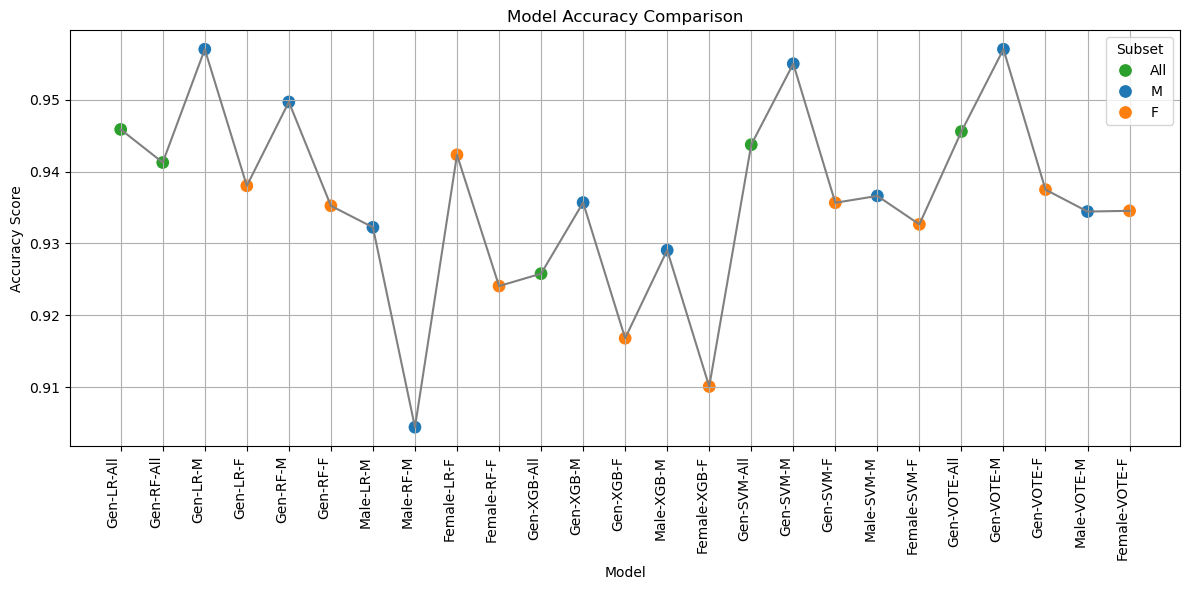

In [166]:
all_results_table = pd.concat([results_table, xgb_results_table, svm_vote_results_table], ignore_index=True)
all_results_table['Subset'] = all_results_table['Model'].str.split('-').str[-1]
palette = {'F': 'tab:orange', 'M': 'tab:blue', 'All': 'tab:green'}
plt.figure(figsize=(12,6))
plt.plot(all_results_table['Model'], all_results_table['Accuracy_mean'], color='gray')
sns.scatterplot(data=all_results_table, x='Model', y='Accuracy_mean', hue='Subset', palette=palette, s=100)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Comparison')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Subset')
plt.show()

## t-tests

In [102]:
from statistics import mean, stdev, NormalDist, StatisticsError
from math import sqrt

from statistics import mean, stdev, NormalDist, StatisticsError
from math import sqrt


In [168]:
# Use paired t-tests to compare model performance on per-fold metrics
import pandas as pd
from itertools import combinations
metric = "accuracy"
all_fold_tables = []
for results in (results_folds, xgb_fold_results, svm_vote_fold_results):
    for model_name, fold_df in results.items():
        df = fold_df.copy()
        df["model"] = model_name
        all_fold_tables.append(df)

fold_metrics = pd.concat(all_fold_tables, ignore_index=True)
parts = fold_metrics["model"].str.split("-", expand=True)
fold_metrics["selection"] = parts[0]
fold_metrics["algorithm"] = parts[1]
fold_metrics["sex"] = parts[2]


#p_value = ttest_rel(baseline_fold_metrics, sex_specific_fold_metrics).pvalue


print(fold_metrics)


      repeat  fold  accuracy        f1  precision    recall   roc_auc  \
0          0     0  0.945946  0.925926   0.961538  0.892857  0.956522   
1          0     1  0.985507  0.984615   1.000000  0.969697  0.991582   
2          0     2  0.974026  0.967742   1.000000  0.937500  0.992361   
3          0     3  0.907895  0.917647   0.975000  0.866667  0.941935   
4          0     4  0.922078  0.928571   1.000000  0.866667  0.948611   
...      ...   ...       ...       ...        ...       ...       ...   
1245       9     0  0.938776  0.918919   1.000000  0.850000  0.886207   
1246       9     1  0.948718  0.923077   1.000000  0.857143  0.945714   
1247       9     2  0.960784  0.928571   1.000000  0.866667  0.968519   
1248       9     3  0.903846  0.883721   0.950000  0.826087  0.892054   
1249       9     4  0.954545  0.956522   1.000000  0.916667  0.916667   

              model selection algorithm  sex  
0        Gen-LR-All       Gen        LR  All  
1        Gen-LR-All       Gen

In [106]:
# collect p-values for Holm-Bonferroni correction

p_values = []
comparisons = []

for alg in fold_metrics["algorithm"].unique():
    for sex in ["M", "F"]:
        baseline_df = fold_metrics[
            (fold_metrics["selection"] == "Gen") &
            (fold_metrics["algorithm"] == alg) &
            (fold_metrics["sex"] == sex)
        ][["repeat", "fold", metric]]
        specific_group = "Male" if sex == "M" else "Female"
        specific_df = fold_metrics[
            (fold_metrics["selection"] == specific_group) &
            (fold_metrics["algorithm"] == alg) &
            (fold_metrics["sex"] == sex)
        ][["repeat", "fold", metric]]
        merged = baseline_df.merge(specific_df, on=["repeat", "fold"], suffixes=("_base", "_spec"))
        if not merged.empty:
            p_value = ttest_rel(merged[f"{metric}_base"], merged[f"{metric}_spec"]).pvalue
            print(f"{alg}-{sex}: p-value={p_value:.4f}")



LR-M: p-value=0.0238
LR-F: p-value=0.3059
RF-M: p-value=0.0038
RF-F: p-value=0.1793
XGB-M: p-value=0.8699
XGB-F: p-value=0.3169
SVM-M: p-value=0.0475
SVM-F: p-value=0.2602
VOTE-M: p-value=0.0413
VOTE-F: p-value=0.3117


In [ ]:
#### TODO
#from scipy.stats import ttest_rel
#import pandas as pd

# Extract AUC scores for each model from the earlier results
# Define model pairs to compare
# Perform t-tests
# Bonferroni correction

# Evaluate all models with cross validation??